##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
orig_df = pd.read_csv('/Users/visheshmehta/College/Semester2/Pr/Hw2/Datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])
orig_df.sample(5)

,X,Y,OBJECTID,Event_Number,ReportedOn,Location,CSZ,Area_Command,Beat,OffenseGroup,NIBRSOffenseCode,VictimCount,Longitude,Latitude,DateDif
178,-115.081646,36.195676,150681,LLV221200086041,2022-12-22 09:23:00+00:00,4200 Block E Lake Mead Blvd,"LAS VEGAS, NV 89115",NEAC,F3,A,09A,0,-115.081646,36.195676,288
91,-115.125507,36.157356,85844,LLV220500009242,2022-05-03 09:35:06+00:00,1700 Block E CHARLESTON BLVD,"LAS VEGAS, NV 89104",DTAC,C4,A,09A,0,-115.125507,36.157356,521
146,-115.130974,36.177318,123061,LLV221100087808,2022-11-23 18:36:00+00:00,700 Block N 11TH ST,"Las Vegas, NV 89101",DTAC,B1,A,09A,0,-115.130974,36.177318,317
67,-115.134246,36.116811,61151,LLV221000046316,2022-10-12 13:32:35+00:00,3900 Block ALGONQUIN DR,"Las Vegas, NV 89119",SCAC,L2,A,09A,0,-115.134246,36.116811,359
232,-115.125655,36.175248,196925,LLV220700012230,2022-07-03 23:29:59+00:00,600 Block N BRUCE ST,"Las Vegas, NV 89101",DTAC,B1,A,09A,0,-115.125655,36.175248,460


In [3]:
orig_df.VictimCount.unique()

array([ 1,  0,  3,  2, 15,  7,  4])

In [4]:
df = pd.read_csv('/Users/visheshmehta/College/Semester2/Pr/Hw2/Datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [5]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [6]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [7]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [8]:
#Task 1(a)

df.sample(5)  #Sample randomly selects 5 rows form the data frame and prints the rows.

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
137,-115.235510,36.244188,8,1,1,17,1
71,-115.178422,36.023796,7,2,0,12,0
50,-115.080502,36.179632,0,1,0,7,0
173,-115.144772,36.114733,5,1,1,8,3
63,-115.135664,36.167869,2,1,4,18,1


## Task 1(a)

* Here first unnamed column is the row number randomly selected from the dataframe. 
* The X and Y are longitude and latitutde respectively, of the location where the crime is reported.
* Area_Command is the code of the department where the crime was investigated.
* NIBRSOffenseCode is simply the category of the crime/offense. For example '09C' code means 'Justifiable Homicide' crime, '09A' 
code means 'Murder & Nonnegligent Manslaughter'. // reference : https://ucr.fbi.gov/nibrs/2011/resources/nibrs-offense-codes
* DayofWeek, as name suggests it represents on which day of the week crime happened, i.e Monday, Tuesday, ...
* Time, again as the name suggest at which time the crime happened in 24-hour format. For example 21 means 9:00 pm, 5 means 5:00 am.
Also, here the time just mentions the hours of the day and not at whihc minute or second.
* Victim Count is the number of persons involved in the crime

## Task 1(b)

* The input variable will be the 6 columns namely, X, Y, Area_Command, NIBRSOffenseCode, DayOfWeek, Time, as we want to train our model on 
these data to predict the VictimCount and hence VictimCount is our target variable.

In [9]:
#Task 1(c)

df.agg(['min', 'max'])

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
min,-116.00000,35.068419,0,0,0,0,0
max,-114.62557,37.000000,11,2,6,23,6


## Task 1(c)

* X,Y : Range is around 1.5° longitude, which makes sense as this data is of crimes reported in las vegas and 1 degree approximately means 69 miles. hence change in around 1.5-2° covers the LA. We need to normalize the latitude and longitude, as they fall far out of the range (min, max value of all other attributes). We can bring the data between 0-2 by subtracting each sample by the minimum of longitude and latitude respectively.
* Area_Command : The range is 12 (0-11), which is factorized. Meaning, there are twelve different are_codes which are encoded into 12 different classes. Hence, 0 represents area1, 1 represents area2, and so on .... Originally the avlues are  array(['NEAC', 'BAC', 'DTAC', 'SVAC', 'CCAC', 'SCAC', 'SAC', 'EAC',
       'NWAC', 'SEAC', 'RO', 'DF'], dtype=object) ==> orig_df.Area_Command.unique()
* NIBRSOffenseCode : the range is 3 (0-2). The reasoning is same as Area_Command, i.e This column is also factorized into three classes. Original values are array(['09C', '09A', '09B'], dtype=object) ==> orig_df.NIBRSOffenseCode.unique()
* DayOfWeek & Time : These columns are aslo similar as above as even these represents class.
* VictimCount : Here VictimCount is also regularized into 7 clasess. The class 0 means o victims involved, 1 means 1 victim involved and so on... Originally the values of VictimCount column are same as the encoded one. Bue we need one hot encoding to let model know that 0,1,2,...6 are just the number of people involved and to not give more importance/weight to higher number, hence we need to factorize this column as well

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [26]:
from sklearn.model_selection import train_test_split


input_value = torch.tensor(df.drop('VictimCount', axis = 1).values.astype(np.float32))
output_value = torch.tensor(df['VictimCount'].values.astype(np.float32))

#Normalizing the data
input_value[:,0] += 116
input_value[:,1] -= 35.068419

X_train, X_test, Y_train, Y_test = train_test_split(input_value, output_value, test_size=0.3)
class LMVPDDataset(Dataset):
    
    def __init__(self, X_data, Y_data):
        self.X_data = X_data
        self.Y_data = Y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.Y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

training_dataset = LMVPDDataset(X_train,Y_train)
train_dataloader = DataLoader(dataset = training_dataset, batch_size = 16, shuffle = False)

test_dataset = LMVPDDataset(X_test,Y_test)
test_dataloader = DataLoader(dataset = test_dataset, batch_size = 16, shuffle = False)

for batches,data in enumerate(train_dataloader):
    x,y = data
    #print("INP: ",x,"TARG : ",y)
    print("Batch: ", batches ," X: ", x.shape," Y: ", y.shape)
    print(x[3,:], "Size: ",x[3,:].shape)
    break

Batch:  0  X:  torch.Size([16, 6])  Y:  torch.Size([16])
tensor([ 0.8652,  1.0463,  5.0000,  1.0000,  2.0000, 14.0000]) Size:  torch.Size([6])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

## Task3

* As this is linear regression model Mean Squared error loss function is appropriate for the network. As Mse will try to reduce the gap/distance netween the predicted value and target/actual value, which is what is required to increase the accuracy of the network.
* The size of the output will be n✖️1, where (n is the number of samples in the data, which is 16 in each batch and 192 in training_dataset.
* Three layers:
* Adam Optimizer  

In [11]:
#Task 3

#creeating the network
from torch import nn
class LMVPDFFNN(nn.Module):
  def __init__(self,input_dimension,output_dimension):
      super(LMVPDFFNN,self).__init__()
      self.activation_function = nn.Sigmoid()  
      self.layer1 = nn.Linear(input_dimension,32) # layer1 input variables : 6 , output : 32 
      self.layer2 = nn.Linear(32,8) # layer2 input variables : 32 (output of layer1) , output : 8
      self.layer3 = nn.Linear(8,1) # layer3 input variables : 8 (output of layer2) , output : 1 (required predicted_output)
  def forward(self,x):      
      a1 = self.layer1(x) # linear output of layer1     
      h1 = self.activation_function(a1) # output from layer 1 after activation (Non-linear output)      
      a2 = self.layer2(h1) # linear output of layer2      
      h2 = self.activation_function(a2) # output from layer 2 after activation (Non-linear output)    
      a3 = self.layer3(h2) # linear output of layer3 3
      predicted_output =  a3 # output from layer 3 after activation
      return predicted_output

In [12]:
LMVPD_model = LMVPDFFNN(X_train.shape[1],1)
print(LMVPD_model)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(LMVPD_model.parameters(), lr=0.001)  
epochs = 300

for epoch in range(epochs):
    for i,(x,y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        #prediction
        y_predicted = LMVPD_model(x)
        #calculating loss
        #print(y_predicted)
        error = loss_function(y_predicted,y.reshape(-1,1))
        #backpropogation        
        error.backward()
        optimizer.step()
    print("Epoch: ",epoch+1," MSE Loss ",error)


LMVPDFFNN(
  (activation_function): Sigmoid()
  (layer1): Linear(in_features=6, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=1, bias=True)
)
Epoch:  1  MSE Loss  tensor(0.6328, grad_fn=<MseLossBackward0>)
Epoch:  2  MSE Loss  tensor(0.6260, grad_fn=<MseLossBackward0>)
Epoch:  3  MSE Loss  tensor(0.6303, grad_fn=<MseLossBackward0>)
Epoch:  4  MSE Loss  tensor(0.6361, grad_fn=<MseLossBackward0>)
Epoch:  5  MSE Loss  tensor(0.6401, grad_fn=<MseLossBackward0>)
Epoch:  6  MSE Loss  tensor(0.6422, grad_fn=<MseLossBackward0>)
Epoch:  7  MSE Loss  tensor(0.6433, grad_fn=<MseLossBackward0>)
Epoch:  8  MSE Loss  tensor(0.6441, grad_fn=<MseLossBackward0>)
Epoch:  9  MSE Loss  tensor(0.6448, grad_fn=<MseLossBackward0>)
Epoch:  10  MSE Loss  tensor(0.6457, grad_fn=<MseLossBackward0>)
Epoch:  11  MSE Loss  tensor(0.6466, grad_fn=<MseLossBackward0>)
Epoch:  12  MSE Loss  tensor(0.6475, grad_fn=<MseLossBackward

tensor(1.0929, grad_fn=<MseLossBackward0>)
VictimCount
0    142
1    100
3     21
2      9
4      1
5      1
6      1
Name: count, dtype: int64


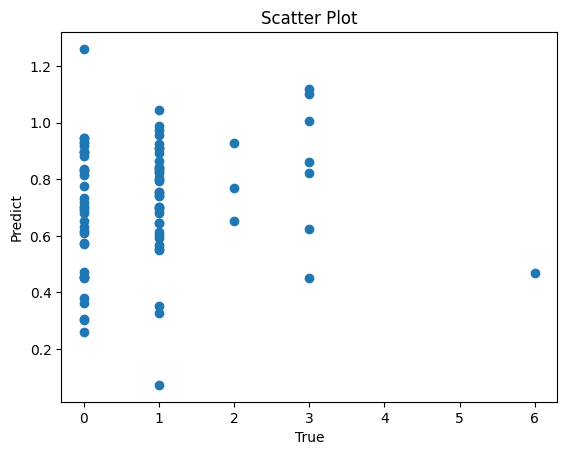

In [13]:
predicted_values_test = LMVPD_model(X_test)
error_test = loss_function(predicted_values_test,Y_test.reshape(-1,1))
print(error_test)
print(df['VictimCount'].value_counts())
plt.title('Scatter Plot')
plt.xlabel('True')
plt.ylabel('Predict')
plt.scatter(Y_test,predicted_values_test.detach().numpy())
plt.show()

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [18]:
#task 4 

class LMVPDFFNNClassification(nn.Module):
  def __init__(self,input_dimension,output_dimension):
      super(LMVPDFFNNClassification,self).__init__()
      self.activation_function = nn.Softmax() # layer1 input variables : 6 , output : 16 
      self.layer1 = nn.Linear(input_dimension,64) # layer2 input variables : 16 (output of layer1) , output : 8  
      self.layer2 = nn.Linear(64,32) # layer3 input variables : 8 (output of layer2) , output : 1 (required predicted_output) 
      self.layer3 = nn.Linear(32,16)
      self.layer4 = nn.Linear(16,output_dimension)
  def forward(self,x):      
      a1 = self.layer1(x) # linear output of layer1     
      h1 = self.activation_function(a1) # output from layer 1 after activation      
      a2 = self.layer2(h1) # linear output of layer2      
      h2 = self.activation_function(a2) # output from layer 2 after activation     
      a3 = self.layer3(h2) # linear output of layer3 
      h3 = self.activation_function(a3)
      a4 = self.layer4(h3)
      predicted_output =  self.activation_function(a4) # output from layer 3 after activation
      return predicted_output

In [27]:
LMVPD_class_model = LMVPDFFNNClassification(X_train.shape[1],7)
print(LMVPD_class_model)
loss_function_class = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(LMVPD_class_model.parameters(), lr=0.001)  
epochs = 300

for epoch in range(epochs):
    accuracy=0
    for i,(x,y) in enumerate(train_dataloader):
        #prediction
        optimizer.zero_grad()
        y_predicted = LMVPD_class_model(x)
        #calculating loss
        error = loss_function_class(y_predicted,y.long())
        #backprop
        error.backward()
        optimizer.step()
    for x, y in test_dataloader:
                correct = 0
                total = 0
                y_hat = LMVPD_class_model(x)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(y_hat.data, 1)
                
                # Total number of labels
                total += y.size(0)
                
                # Total correct predictions
                correct += (predicted == y).sum()
            
                accuracy = 100 * correct / total
            
            # Print Loss
    print('Loss: {}. Accuracy: {}'.format(error.item(), accuracy))

LMVPDFFNNClassification(
  (activation_function): Softmax(dim=None)
  (layer1): Linear(in_features=6, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=7, bias=True)
)
Loss: 1.9178754091262817. Accuracy: 66.66666412353516
Loss: 1.9132611751556396. Accuracy: 66.66666412353516
Loss: 1.9085803031921387. Accuracy: 66.66666412353516
Loss: 1.9038329124450684. Accuracy: 66.66666412353516
Loss: 1.8990224599838257. Accuracy: 66.66666412353516
Loss: 1.8941539525985718. Accuracy: 66.66666412353516
Loss: 1.8892333507537842. Accuracy: 66.66666412353516
Loss: 1.8842670917510986. Accuracy: 66.66666412353516
Loss: 1.879262089729309. Accuracy: 66.66666412353516
Loss: 1.8742254972457886. Accuracy: 66.66666412353516
Loss: 1.8691647052764893. Accuracy: 66.66666412353516
Loss: 1.8640873432159424. Accuracy: 66.66666412353516
Loss: 1.8590008020401. Accuracy: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Loss: 1.804498314857483. Accuracy: 66.66666412353516
Loss: 1.7998404502868652. Accuracy: 66.66666412353516
Loss: 1.7952545881271362. Accuracy: 66.66666412353516
Loss: 1.790744662284851. Accuracy: 66.66666412353516
Loss: 1.786313772201538. Accuracy: 66.66666412353516
Loss: 1.7819643020629883. Accuracy: 66.66666412353516
Loss: 1.7776981592178345. Accuracy: 66.66666412353516
Loss: 1.77351713180542. Accuracy: 66.66666412353516
Loss: 1.7694215774536133. Accuracy: 66.66666412353516
Loss: 1.7654119729995728. Accuracy: 66.66666412353516
Loss: 1.7614881992340088. Accuracy: 66.66666412353516
Loss: 1.7576488256454468. Accuracy: 66.66666412353516
Loss: 1.753894329071045. Accuracy: 66.66666412353516
Loss: 1.75022292137146. Accuracy: 66.66666412353516
Loss: 1.7466334104537964. Accuracy: 66.66666412353516
Loss: 1.7431236505508423. Accuracy: 66.66666412353516
Loss: 1.7396928071975708. Accuracy: 66.66666412353516
Loss: 1.7363383769989014. Accuracy: 66.66666412353516
Loss: 1.733060359954834. Accuracy: 6

## Task 5

torch.Size([83])
torch.Size([83])
Input Sample  tensor([ 0.8690,  1.1089,  2.0000,  1.0000,  6.0000, 11.0000])
Predicted class for the above sample  tensor(0)
Actual/Target calss for the sample  tensor(1.)
Probabilities of each class predicted by the network  tensor([9.9441e-01, 4.8081e-03, 1.5547e-04, 2.2152e-04, 1.5858e-04, 1.2366e-04,
        1.2331e-04], grad_fn=<SelectBackward0>)


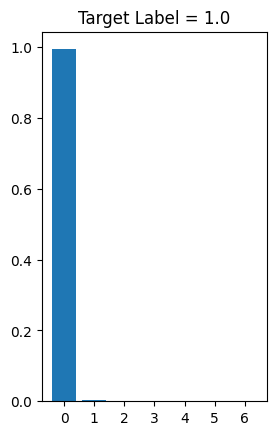

In [16]:
y_hat = LMVPD_class_model(X_test)
# Get predictions from the maximum value
_, predicted = torch.max(y_hat.data, 1)


print(predicted.shape)
print(Y_test.shape)
misclassified_sample=0
for i in range(len(predicted)):
    if(predicted[i] != Y_test[i]):
        misclassified_sample = i
        break

print("Input Sample ",X_test[misclassified_sample])
print("Predicted class for the above sample ",predicted[misclassified_sample])
print("Actual/Target calss for the sample ",Y_test[misclassified_sample])
print("Probabilities of each class predicted by the network ",y_hat[misclassified_sample])

ax = plt.subplot(121)
ax.bar(range(7),y_hat[misclassified_sample].detach().numpy())
ax.set_xticks(range(7))
plt.title('Target Label = {}'.format(Y_test[misclassified_sample].detach().numpy()));

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

## Task 5

* In linear regression, we tried to predict a real number for the number of victims involved given the dataset. But as the number of victims are classified a real number doesn't make much sense. (Also, in real world 0.5 person has no meaning). So, theoratically we can create a artifical neural network model and train it with dataset, but we can't rely on that model to give correct prediction for most of the data.
  
* In the classification neural network we trained the model to give the probabilities of each class (VictimCount). The model did improve a bit compared to the linear regression but it depends on the data split (train and test). For some data split thee accuracy is 33% and for others its 66%. Also there is saturation in reduction of loss after some point. Which I believe is because there is no trong relation or dependency between the input dimesnions and VictimCount. the number of persons involved in the crime does'nt have corelation with any other variable and hence the accuracy flucuates and doesn't improve much.

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


In [28]:
df['X'] += 116
df['Y'] -= 35.068419

0      0.912482
1      0.759828
2      0.856912
3      0.774986
4      0.823292
         ...   
270    0.885261
271    0.919236
272    0.827927
273    0.847407
274    0.939655
Name: X, Length: 275, dtype: float64


## Task6

* There seems no pattern on the data as there is no significant change in the reported crimes between each day of the week. The range is 23, but the max is 51 and min is 28 hence can't say that the crimes depends on the day.
* In the second scatter plot the victim counts are mostly either 0 or 1 wth few outlieers with victimCount having class 3,4,5,6. But even here there is no such pattern based on the location. There is no distinct boundry that in these locationa, victim count is 0 and at the other locations 1.

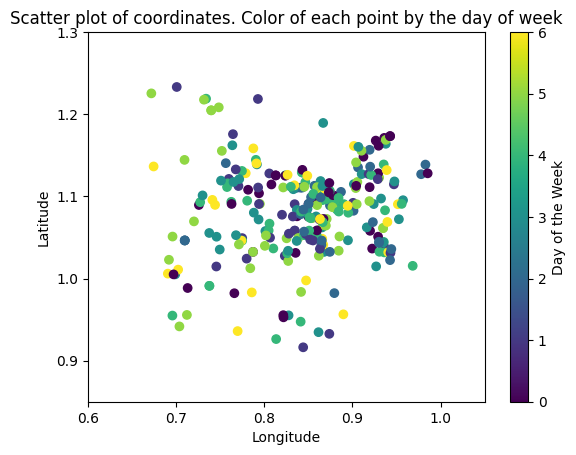

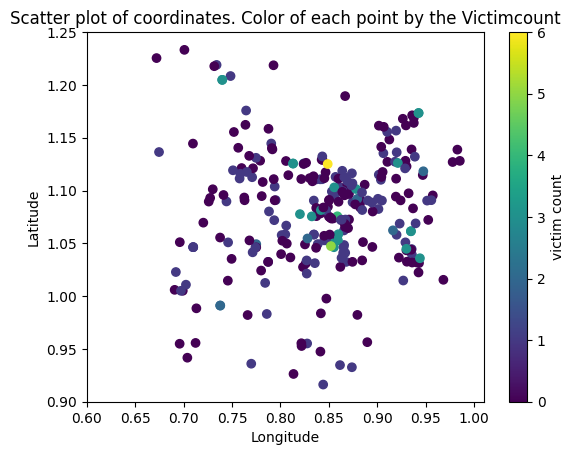

Recorded crimes each day
DayOfWeek
4    51
3    44
5    43
0    40
1    37
2    32
6    28
Name: count, dtype: int64
4


In [32]:
#Scatter plot of coordinates. Color of each point by the day of week
plt.scatter(x=df['X'], y=df['Y'], c = df['DayOfWeek'], cmap='viridis')
plt.colorbar(label='Day of the Week')
plt.title('Scatter plot of coordinates. Color of each point by the day of week')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(0.6, 1.05)
plt.ylim(0.85, 1.3)
plt.show()

#Scatter plot of coordinates. Color of each point by the VictimCount
plt.scatter(x=df['X'], y=df['Y'], c = df['VictimCount'], cmap='viridis')
plt.colorbar(label='victim count')
plt.title('Scatter plot of coordinates. Color of each point by the Victimcount')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(0.6,1.01)
plt.ylim(0.90,1.25)
plt.show()

plt.show()
# Sort number of crimes reported by day of the week
crimes_per_day = df['DayOfWeek'].value_counts()
print("Recorded crimes each day")
print(crimes_per_day)

# Get the most frequent days
most_frequent_days = crimes_per_day.idxmax()
print(most_frequent_days)